# Modelling
In this notebook, I am going to fit a Machine Learning model on the data to predict whether a person earns more than 50k a year.

I chose R because it will be easier for me to integrate this model inside a user-interface later with Rshiny. But R is less powerful and more limited in ML models than Python. 

In [ ]:
library(dplyr)
library(randomForest)
library(rfUtilities)
options(repr.plot.width = 7, repr.plot.height = 5, warn = FALSE)

In [2]:
## Import the data
col_names <- c('age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship',
               'race','sex','capital-gain','capital-loss','hours-per-week','native-country','class')

train <- read.csv('../data/adult.data', col.names = col_names, strip.white = TRUE, colClasses = c('integer', 'character', 'character', 'character', 'character', 'character', 'character', 'character', 'integer', 'integer', 'integer', 'factor'))
train[train == '?'] <- NA

train$fnlwgt <- NULL; train$education.num <- NULL
train <- train[complete.cases(train), ]

I am first fitting a Random Forest on the original training dataset. I am using cross-validation to measure the goodness of fit of the model on the data.

In [3]:
## Fit a Random Forest
rf <- randomForest(select(train, -class), train$class, ntree = 80, block.size = 1, importance = T, na.action = na.omit)
rf.cv <- rf.crossValidation(rf, xdata = select(train, -class), n = 20, ntree = 80)

# Variables importance
rf$importance[order(rf$importance[, 3], decreasing = TRUE),]

running: classification cross-validation with 20 iterations 


,<=50K,>50K,MeanDecreaseAccuracy,MeanDecreaseGini
marital.status,0.038264127,0.0776171147,0.048077416,1051.4301
capital.gain,0.031953473,0.0646307650,0.040097825,1268.9247
relationship,0.030527942,0.0686073213,0.040022222,1125.4439
education,0.017833581,0.0631933384,0.029139732,1136.3230
occupation,0.016009726,0.0597278757,0.026913045,963.7713
age,0.001239664,0.0705768353,0.018525597,1137.0543
hours.per.week,0.003098813,0.0287617821,0.009499406,660.8087
capital.loss,0.004843006,0.0224981894,0.009243450,365.5566
sex,0.008032996,0.0028987661,0.006755757,115.0923
workclass,0.006624901,0.0040354346,0.005980181,361.1253


The most important variables of this model are *marital status*, *relationship*, and *capital gain*. In particular, the ones most useful to detect people in the ">50K" class are *relationship* and *age*.

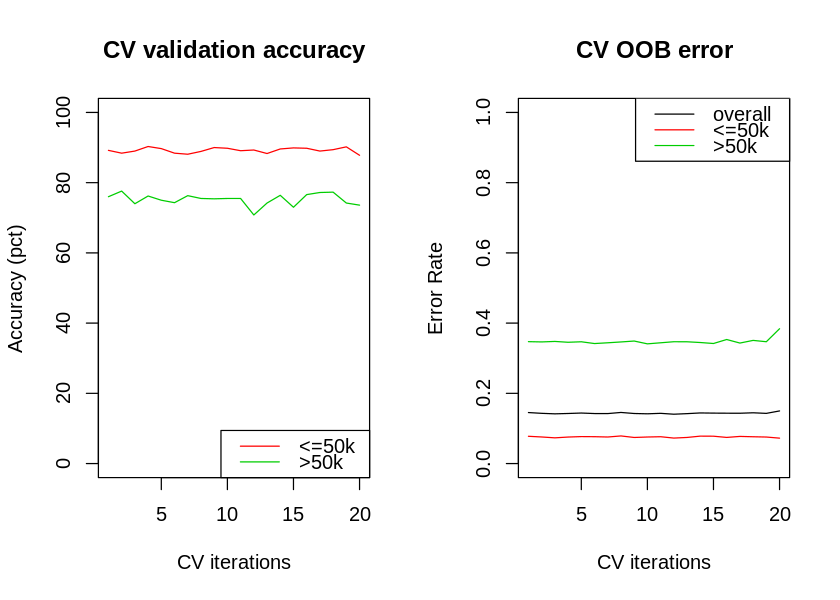

In [4]:
# Plot cross validation verses model producers accuracy
par(mfrow=c(1,2)) 
matplot(rf.cv$cross.validation$cv.producers.accuracy, type = 'l', lty = 1, col = 2:3, ylim = c(0, 100), xlab = 'CV iterations', ylab = 'Accuracy (pct)', main = 'CV validation accuracy')
legend('bottomright', legend = c('<=50k', '>50k'), col = 2:3, lty = 1)

matplot(rf.cv$cross.validation$cv.oob[ , 1:3], type = 'l', lty = 1, col = 1:3, ylim = c(0, 1), xlab = 'CV iterations', ylab = 'Error Rate', main = 'CV OOB error')
legend('topright', legend = c('overall', '<=50k', '>50k'), col = 1:3, lty = 1)

The cross-validation accuracy of this model is 89% for the "<=50K" class and 75% for the ">50K" class.  
The error rate on the other hand is 14% overall, with 34% for ">50K" and only 7.6% for "<=50K".

---

Our goal is to detect potential donors. We want to predict the ">50K" people better, even if it means detecting people from the other class too. The accuracy for ">50K" is lower because the training dataset is unbalanced: we have a lot more observations in the "<=50K" class than in the ">50K" class.

To balance the dataset, I am over-sampling the ">50K" class to 15,000 observations, and under-sampling the "<=50K" class to 15,000 observations.

In [5]:
## Re-sampling the classes
train.low  <- sample_n(train %>% filter(class == "<=50K"), 15000, replace = F)
train.high <- sample_n(train %>% filter(class == ">50K"), 10000, replace = T)

train.balance <- rbind(train.low, train.high)                 # merge the two classes data
train.balance <- train.balance[sample(nrow(train.balance)), ] # shuffle the data

In [6]:
## Fit a Random Forest
rf <- randomForest(select(train.balance, -class), train.balance$class, ntree = 80, block.size = 1, importance = T, na.action = na.omit)
rf.cv <- rf.crossValidation(rf, xdata = select(train.balance, -class), n = 20, ntree = 80)

# Variables importance
rf$importance[order(rf$importance[, 3], decreasing = TRUE),]

running: classification cross-validation with 20 iterations 


,<=50K,>50K,MeanDecreaseAccuracy,MeanDecreaseGini
relationship,4.477896e-02,0.12687893,0.077633244,1654.9729
marital.status,5.010412e-02,0.08963750,0.065936530,1253.9443
education,2.884176e-02,0.11313266,0.062549935,1263.6941
age,4.397306e-03,0.14263784,0.059686476,1377.3568
occupation,2.364477e-02,0.11299775,0.059379822,1050.6367
capital.gain,4.786976e-02,0.05323310,0.050013813,1055.2994
hours.per.week,4.919438e-03,0.07954798,0.034766788,724.5069
workclass,6.898050e-03,0.03396424,0.017725348,361.8866
capital.loss,6.740894e-03,0.02378475,0.013561722,317.1484
sex,8.845675e-03,0.01946845,0.013086740,143.5335


The most important variables of this new model are now *relationship*, *marital status* and *occupation*. The variables most useful to detect ">50K" are *age* and *occupation*.

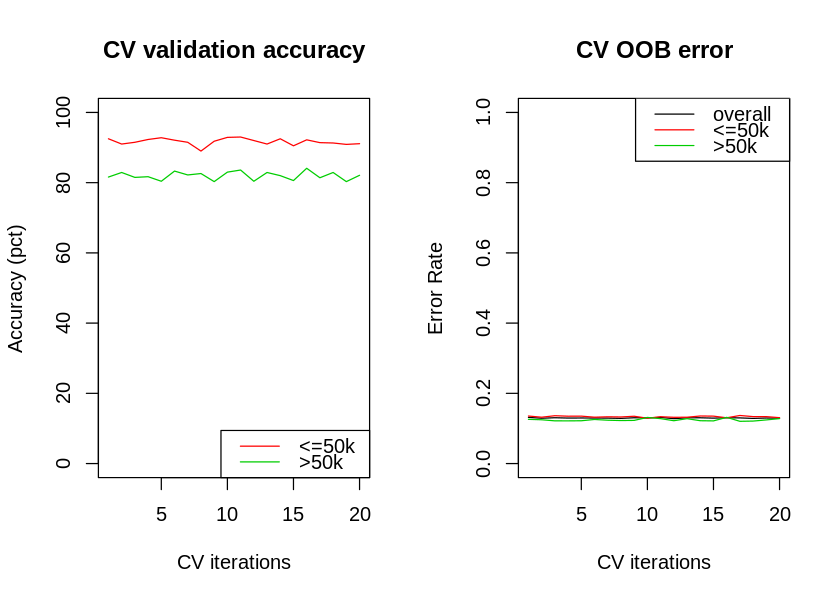

In [7]:
# Plot cross validation verses model producers accuracy
par(mfrow=c(1,2)) 
matplot(rf.cv$cross.validation$cv.producers.accuracy, type = 'l', lty = 1, col = 2:3, ylim = c(0, 100), xlab = 'CV iterations', ylab = 'Accuracy (pct)', main = 'CV validation accuracy')
legend('bottomright', legend = c('<=50k', '>50k'), col = 2:3, lty = 1)

matplot(rf.cv$cross.validation$cv.oob[ , 1:3], type = 'l', lty = 1, col = 1:3, ylim = c(0, 1), xlab = 'CV iterations', ylab = 'Error Rate', main = 'CV OOB error')
legend('topright', legend = c('overall', '<=50k', '>50k'), col = 1:3, lty = 1)

The accuracy for both class is higher and closer: 92% for "<=50K" and 83% for ">50K".   
The error rate is now 13% for both classes. We are now detecting people in ">50K" as well as the other class. The overall accuracy is also slightly better than with the previous model.

--- 

Last thing I am trying is apply my variables changes from the EDA part.

In [8]:
df <- train

# workclass
df$workclass <- as.character(df$workclass)
df$workclass[df$workclass %in% c('Never-worked','Without-pay')] <- 'Unemployed'
df$workclass <- factor(df$workclass)

# education
df$education <- as.character(df$education)
df$education[df$education %in% c('Preschool', '1st-4th')]    <- 'before-4th'
df$education[df$education %in% c('5th-6th','7th-8th','9th')] <- '5th-9th'
df$education[df$education %in% c('10th', '11th', '12th')]    <- '10th-12th'
df$education[df$education %in% c('HS-grad', 'Some-college')] <- 'HS-grad'
df$education[df$education %in% c('Assoc-acdm', 'Assoc-voc')] <- 'Assoc'
df$education[df$education %in% c('Doctorate','Prof-school')] <- 'Doc-prof'
df$education <- factor(df$education, ordered = TRUE, levels = c('before-4th','5th-9th','10th-12th','HS-grad','Assoc','Bachelors','Masters','Doc-prof'))

# marital status
df$marital.status <- as.character(df$marital.status)
df$marital.status[df$marital.status %in% c('Married-AF-spouse','Married-civ-spouse')] <- 'Married'
df$marital.status[df$marital.status %in% c('Married-spouse-absent','Widowed')] <- 'Widowed-Spouse-absent'
df$marital.status <- factor(df$marital.status)

# occupation
df$occupation <- as.character(df$occupation)
df$occupation[df$occupation %in% c('Priv-house-serv','Other-service')] <- 'Other-service'
df$occupation[df$occupation %in% c('Armed-Forces','Farming-fishing','Machine-op-inspct')] <- 'Other-occupation'
df$occupation[df$occupation %in% c('Sales','Tech-support')] <- 'Office-service'
df$occupation <- factor(df$occupation)

# relationship
df$relationship <- as.character(df$relationship)
df$relationship[df$relationship %in% c('Other-relative','Own-child')] <- 'With-relative'
df$relationship[df$relationship %in% c('Not-in-family','Unmarried')] <- 'Not-in-family'
df$relationship[df$relationship %in% c('Husband','Wife')] <- 'Married'
df$relationship <- factor(df$relationship)

# native country
df$native.country <- as.character(df$native.country)
df$native.country[df$native.country %in% c('United-States','Canada','Outlying-US(Guam-USVI-etc)')] <- 'north-america'
df$native.country[df$native.country %in% c('Cuba','Puerto-Rico','Dominican-Republic','Haiti','Jamaica')] <- 'carribean'
df$native.country[df$native.country %in% c('Honduras','Guatemala','Nicaragua','El-Salvador','Trinadad&Tobago','Peru','Columbia','Ecuador')] <- 'south-america'
df$native.country[df$native.country %in% c('England','Holand-Netherlands','Ireland','Hungary','Greece','Scotland','Germany','Yugoslavia','Poland','Portugal','France','Italy')] <- 'europe'
df$native.country[df$native.country %in% c('China','Hong','Japan','Philippines','India','Vietnam','Cambodia','Thailand','South','Iran','Laos','Taiwan')] <- 'asia'
df$native.country <- factor(df$native.country)

# Race
df$race <- factor(df$race, levels = c('White','Asian-Pac-Islander','Black','Amer-Indian-Eskimo','Other'))

# Re-sampling the classes
df.low  <- sample_n(df %>% filter(class == "<=50K"), 15000, replace = F)
df.high <- sample_n(df %>% filter(class == ">50K"), 10000, replace = T)

df.balance <- rbind(df.low, df.high)                 # merge the two classes data
df.balance <- df.balance[sample(nrow(df.balance)), ] # shuffle the data

running: classification cross-validation with 20 iterations 


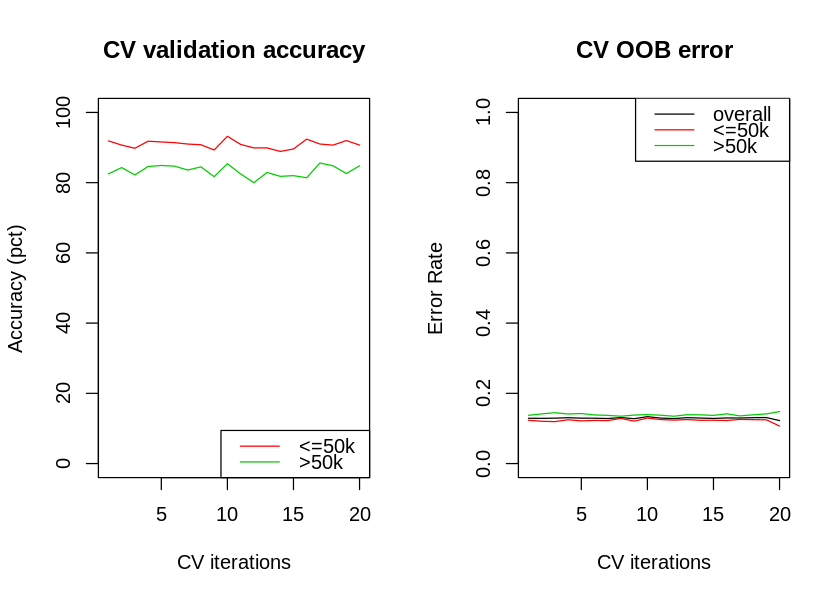

In [9]:
## Fit a Random Forest
rf <- randomForest(select(df.balance, -class), df.balance$class, ntree = 80, block.size = 1, importance = T, na.action = na.omit)
rf.cv <- rf.crossValidation(rf, xdata = select(df.balance, -class), n = 20, ntree = 80)

# Plot cross validation verses model producers accuracy
par(mfrow=c(1,2)) 
matplot(rf.cv$cross.validation$cv.producers.accuracy, type = 'l', lty = 1, col = 2:3, ylim = c(0, 100), xlab = 'CV iterations', ylab = 'Accuracy (pct)', main = 'CV validation accuracy')
legend('bottomright', legend = c('<=50k', '>50k'), col = 2:3, lty = 1)

matplot(rf.cv$cross.validation$cv.oob[ , 1:3], type = 'l', lty = 1, col = 1:3, ylim = c(0, 1), xlab = 'CV iterations', ylab = 'Error Rate', main = 'CV OOB error')
legend('topright', legend = c('overall', '<=50k', '>50k'), col = 1:3, lty = 1)

The accuracy for both class, and the error rates are still the same as the previous model.   
There is no need to transform the variables like before.

--- 

I can finally train and save the best model I have, with a more balanced dataset.

In [11]:
## Fit a Random Forest
rf <- randomForest(select(train.balance, -class), train.balance$class, ntree = 100, block.size = 1, importance = F, na.action = na.omit)
save(rf, file = '../data/model.rda')